In [3]:
!pip install ucimlrepo

In [140]:
# Import necessary libraries
import pandas as pd
from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split, KFold
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np

In [141]:
def load_and_preprocess_data():
    # Fetch and load the dataset
    car_evaluation = fetch_ucirepo(id=19)
    X = car_evaluation.data.features
    y = car_evaluation.data.targets

    # One-Hot Encode categorical features
    X_encoded = pd.get_dummies(X)

    # Encode the target variable using LabelEncoder
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    return X_encoded, y_encoded, label_encoder

In [142]:
def build_model(input_dim, num_classes):
    # Build the model
    model = keras.Sequential([
        layers.Dense(16, activation='relu', input_shape=(input_dim,)),
        layers.Dense(8, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])

    # Compile the model
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [143]:
def train_model(model, X_train, y_train):
    # Train the model
    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=16,
        validation_split=0.1,
        verbose=0  
    )

    return history

In [144]:
def plot_confusion_matrix(true_labels, predicted_labels, classes, fold_number):
    # Plot the confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels, labels=classes)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(f'Confusion Matrix - Fold {fold_number}')
    plt.savefig(f'confusion_matrix_fold_{fold_number}.png')
    plt.show()

In [145]:
def plot_roc_curve_ovr(model, X, y, label_encoder):
    """
    Plots a one-vs-rest ROC curve for each class in a multiclass setting.
    """
    # Predict probabilities
    y_score = model.predict(X)

    # Binarize the output labels for ROC computation
    num_classes = len(label_encoder.classes_)
    y_binarized = label_binarize(y, classes=range(num_classes))

    # Initialize plot
    plt.figure()
    colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown']

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_binarized[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], color=colors[i % len(colors)],
                 lw=2, label=f'ROC curve of class {label_encoder.classes_[i]} (area = {roc_auc[i]:0.2f})')

    # Plot micro-average ROC curve
    fpr["micro"], tpr["micro"], _ = roc_curve(y_binarized.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    plt.plot(fpr["micro"], tpr["micro"],
             label=f'micro-average ROC curve (area = {roc_auc["micro"]:0.2f})',
             color='deeppink', linestyle=':', linewidth=4)

    # Plot reference line
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('One-vs-Rest ROC Curve for Multiclass Classification')
    plt.legend(loc='lower right')
    plt.show()

In [146]:
def evaluate_model(model, X_test, y_test, label_encoder, fold_number):
    """
    Evaluates the trained model on the test set, computes ROC curves, MSE, and returns metrics.
    """
    # Evaluate on the test set
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"\nFold {fold_number} - Test Accuracy: {test_accuracy:.4f}")
    print(f"Fold {fold_number} - Test Loss: {test_loss:.4f}")

    # Make predictions (probabilities)
    y_score = model.predict(X_test)

    # Binarize the output labels for MSE computation and ROC curves
    num_classes = len(label_encoder.classes_)
    y_test_binarized = label_binarize(y_test, classes=range(num_classes))

    # Compute MSE using true probabilities and predicted probabilities
    mse = mean_squared_error(y_test_binarized, y_score)
    print(f"Fold {fold_number} - MSE: {mse:.4f}")

    # Generate classification report
    predicted_classes = tf.argmax(y_score, axis=1).numpy()
    predicted_labels = label_encoder.inverse_transform(predicted_classes)
    true_labels = label_encoder.inverse_transform(y_test)
    report = classification_report(true_labels, predicted_labels, output_dict=False)
    print(f"Fold {fold_number} - Classification Report:\n{report}")

    return test_loss, test_accuracy, mse, report

In [147]:
def main():
    # Load and preprocess data
    X_encoded, y_encoded, label_encoder = load_and_preprocess_data()

    # Define number of splits for K-Fold
    n_splits = 5  

    # Initialize KFold
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Lists to store metrics for each fold
    fold_accuracies = []
    fold_losses = []
    fold_mses = []
    fold_reports = []

    # Start K-Fold Cross-Validation
    fold_number = 1
    for train_index, test_index in kf.split(X_encoded):
        print(f"\nStarting Fold {fold_number}/{n_splits}")

        # Split data into training and testing sets for this fold
        X_train, X_test = X_encoded.iloc[train_index], X_encoded.iloc[test_index]
        y_train, y_test = y_encoded[train_index], y_encoded[test_index]

        # Get input dimensions and number of classes
        input_dim = X_train.shape[1]
        num_classes = len(label_encoder.classes_)

        # Build the model
        model = build_model(input_dim, num_classes)

        # Train the model
        history = train_model(model, X_train, y_train)

        # Evaluate the model and collect results
        test_loss, test_accuracy, mse, report = evaluate_model(model, X_test, y_test, label_encoder, fold_number)

        # Store metrics for this fold
        fold_accuracies.append(test_accuracy)
        fold_losses.append(test_loss)
        fold_mses.append(mse)
        fold_reports.append(report)

        fold_number += 1

    # Calculate and print average metrics
    avg_accuracy = np.mean(fold_accuracies)
    avg_loss = np.mean(fold_losses)
    avg_mse = np.mean(fold_mses)
    print(f"\nAverage Test Accuracy over {n_splits} folds: {avg_accuracy:.4f}")
    print(f"Average Test Loss over {n_splits} folds: {avg_loss:.4f}")
    print(f"Average MSE over {n_splits} folds: {avg_mse:.4f}")

    # Train final model on the entire dataset
    final_model = build_model(input_dim, num_classes)
    final_model.fit(X_encoded, y_encoded, epochs=50, batch_size=16, verbose=0)

    # Generate ROC curve for one vs rest multiclass
    plot_roc_curve_ovr(final_model, X_encoded, y_encoded, label_encoder)

/opt/anaconda3/envs/MLE/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Starting Fold 1/5

Fold 1 - Test Accuracy: 0.9653
Fold 1 - Test Loss: 0.0877
11/11 [==============================] - 0s 263us/step
Fold 1 - MSE: 0.0122
Fold 1 - Classification Report:
              precision    recall  f1-score   support

         acc       0.99      0.93      0.96        83
        good       0.75      0.55      0.63        11
       unacc       0.99      1.00      0.99       235
       vgood       0.71      1.00      0.83        17

    accuracy                           0.97       346
   macro avg       0.86      0.87      0.85       346
weighted avg       0.97      0.97      0.97       346


Starting Fold 2/5

Fold 2 - Test Accuracy: 0.9827
Fold 2 - Test Loss: 0.0618
11/11 [==============================] - 0s 274us/step
Fold 2 - MSE: 0.0082
Fold 2 - Classification Report:
              precision    recall  f1-score   support

         acc       0.96      0.99      0.97        73
        good       0.89      0.89      0.89        18
       unacc       1.00      0

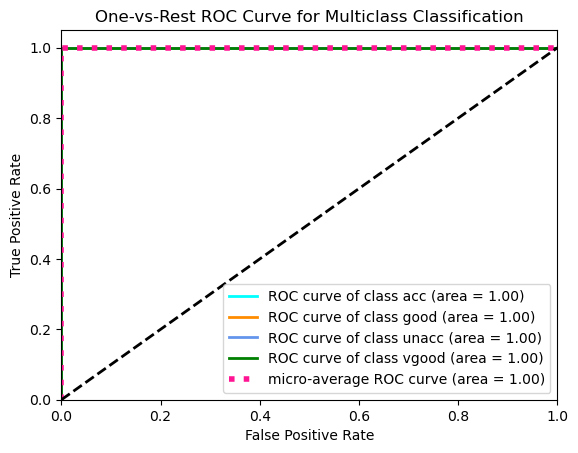

In [148]:
if __name__ == "__main__":
    main()